In [3]:
"""
Pulse generator PySpice model for Fig.5 of the uploaded paper.
Simplified SRD + GDT model. Citation: High-Power Nanosecond Pulse Generator (Nikoo & Hashemi). :contentReference[oaicite:1]{index=1}
"""

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Simulation import *
from PySpice.Probe.Plot import plot
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Circuit parameters (from paper Tables I-III)
# ----------------------------
A1 = 55    # negative amplitude (V)
A2 = 150   # positive amplitude (V)
T1 = 1.0e-6    # forward section duration (s)  (paper: 1.0 us)
T2 = 0.5e-6    # reverse/positive section duration (s)  (paper: 0.5 us)
period = T1 + T2

L_value = 0.1e-6   # 0.1 uH (Table I)
R1 = 16.0          # ohm (Table III R1)
R2 = 16.0          # chosen = R1 in discussion (use R2 ~16)
Rs = 0.1           # series small resistor for D2 branch (Table I RS = 0.1 ohm)
RL = 50.0          # load ohm (we simulate with 50 ohm load)
Cdsc_value = 16e-9 # 16 nF discharge capacitance (Table III)
Cj1 = 9e-12        # D1 zero-bias junction capacitance (≈9 pF in paper -> used 9e-12 F)
Cj2 = 1400e-12     # D2 junction capacitance (~1400 pF in paper)
CGDT = 1e-12       # GDT electrode capacitance (1 pF)
Vb = 50.0          # GDT breakdown threshold (V) - chosen so A1 > Vb
# NOTE: tweak Vb to match the paper's timing in simulation.

# Diode model parameters (very approximate; tune as needed)
IS_D1 = 1e-9
IS_D2 = 1e-6
RS_D1 = 0.1    # series resistance to mimic on resistance
RS_D2 = 0.01

# ----------------------------
# Build circuit
# ----------------------------
circuit = Circuit('Dual-Diode Pulse Generator (Fig.5 simplified)')

# Bipolar rectangular source: PULSE(Vinitial Vpulse td tr tf ton period)
# We want negative section (-A1) for T1, then positive (+A2) for T2
# To represent that with a single PULSE we set:
#  - initial = -A1
#  - pulsed  = +A2
#  - on-time = T2 (duration of +A2)
#  - period  = T1 + T2
circuit.PulseVoltageSource('Vin', 'vin', circuit.gnd,
                           -A1@u_V, A2@u_V,
                           0@u_s,            # delay
                           1e-9@u_s,         # rise time (1 ns)
                           1e-9@u_s,         # fall time (1 ns)
                           T2@u_s,           # on-time (time at +A2)
                           period@u_s)       # period

# Inductor
circuit.L('L1', 'vin', 'node', L_value@u_H)

# Load RL from node to ground
circuit.R('L', 'node', circuit.gnd, RL@u_Ohm)

# D1 branch (high-voltage SRD)
# Node naming:
#  node  = node after L (connected to RL and top node)
#  d1_n  = junction node for D1 and Cdsc and R2 to ground
circuit.D('1', 'node', 'd1_n', model='D1m')      # diode from node -> d1_n (anode at d1_n)
circuit.R('2', 'd1_n', circuit.gnd, R2@u_Ohm)   # R2 to ground
circuit.C('dsc', 'd1_n', 'gdt_ctrl', Cdsc_value@u_F)  # Cdsc from D1 node to GDT node

# D2 branch (high-current diode + GDT)
# We'll create a small branch: node -> gdt_node -> d2_node -> RS -> ground
circuit.SinusoidalVoltageSource  # keep namespace

# Create GDT control node (gdt_ctrl). The GDT is modeled using a voltage controlled switch Sg
# We create a low-capacitance GDT electrode node between node and d2_n
# Sg will connect node to gdt_electrode when V(node,gnd) > Vb
circuit.R('gdt_cap', 'gdt_ctrl', 'gdt_elec', CGDT@u_Ohm) # placeholder: small impedance (we will also create explicit C across if needed)
# but better to put an explicit capacitor from gdt_elec to ground:
circuit.C('gdt_c', 'gdt_elec', circuit.gnd, CGDT@u_F)

# Model D2 path: node -> gdt_elec (when switch closes) -> d2_n -> Rs -> ground
# Use an ideal switch (S) controlled by V(node) - V(gdt_ctrl) with threshold Vt=Vb
# In SPICE, switch syntax: Sname N+ N- NC+ NC- <model>
# We'll create the switch S_gdt between 'node' and 'gdt_elec', controlled by control voltage at nodes 'node' and 'gdt_ctrl'.
circuit.S('GDT', 'node', 'gdt_elec', 'node', 'gdt_ctrl', model='SWGDT')

# D2 diode from gdt_elec -> d2_n
circuit.D('2', 'gdt_elec', 'd2_n', model='D2m')    # anode at d2_n (so direction set accordingly)
circuit.R('s', 'd2_n', circuit.gnd, Rs@u_Ohm)

# Series small resistor RS added already as R('s')

# Diode models
circuit.model('D1m', 'D', IS=IS_D1, RS=RS_D1, CJO=Cj1)
circuit.model('D2m', 'D', IS=IS_D2, RS=RS_D2, CJO=Cj2)

# Switch model for GDT (SW type) - Ron when ON and Roff when OFF with threshold Vt (Vb).
# .model SWGDT SW(Ron=0.01 Roff=1Meg Vt=Vb Vh=1)
circuit.model('SWGDT', 'SW', Ron=1e-3, Roff=1e9, Vt=Vb, Vh=1.0)

# Probe nodes: measure voltage at 'node' (load node) and 'd1_n'
# Add ground reference
circuit.Ground = circuit.gnd

# ----------------------------
# Simulation
# ----------------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# transient step size: choose sufficiently small to see nanosecond edges, but keep it reasonable
step_time = 100e-12  # 100 ps
end_time = 3 * period  # simulate 3 cycles

print("Running transient simulation...")
analysis = simulator.transient('transient',step_time@u_s,end_time@u_s)

# ----------------------------
# Extract and plot results
# ----------------------------
time = np.array(analysis.time)

# Node voltages
v_node = np.array(analysis.nodes['node'])
v_d1n  = np.array(analysis.nodes['d1_n'])
v_gdtelec = np.array(analysis.nodes['gdt_elec'])

plt.figure(figsize=(10,6))
plt.plot(time * 1e6, v_node, label='V_load (node)')
plt.plot(time * 1e6, v_d1n, label='V_d1_n', alpha=0.7)
plt.plot(time * 1e6, v_gdtelec, label='V_gdt_elec', alpha=0.6)
plt.xlabel('Time (us)')
plt.ylabel('Voltage (V)')
plt.title('Load voltage and internal node voltages (simplified Fig.5 model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

'''
# Save CSV
import csv
with open('pulse_sim_results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['time_s','v_node_V','v_d1n_V','v_gdt_elec_V'])
    for t, vn, vd1, vg in zip(time, v_node, v_d1n, v_gdtelec):
        writer.writerow([float(t), float(vn), float(vd1), float(vg)])

print("Simulation finished. Results saved to pulse_sim_results.csv")
'''

Running transient simulation...


ValueError: could not convert string to float: 't'

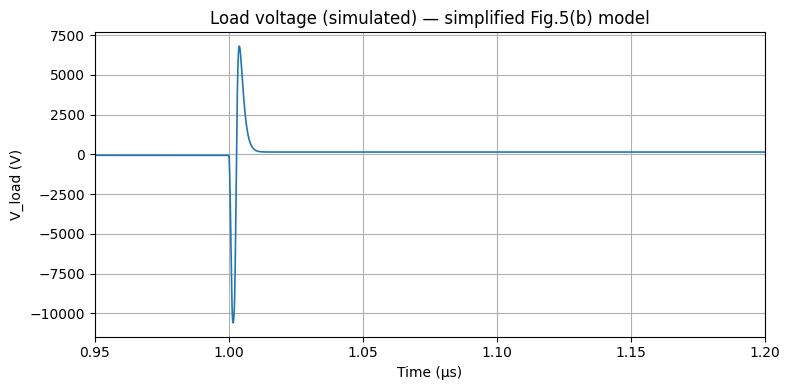

"\n# save data for inspection\nnp.savetxt('pulse_fig5b_vload.txt', np.column_stack((time, v_load)), header='time(s) v_load(V)')\nprint('Simulation complete. Data saved to pulse_fig5b_vload.txt')\n"

In [4]:
# pulse_fig5b.py
# PySpice example that simulates the reverse-bias RLC transient of Fig.5(b)
# Approximates the SRD/GDT snap-off by injecting a short current pulse (Iinj).
# Requirements: PySpice + ngspice installed. See notes below.

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# User tunable parameters (match to paper / tune experimentally)
# ---------------------------
L_value   = 0.1e-6     # H  (0.1 µH from Table I)
Ceff      = 10e-12     # F  (~10 pF; adjust to match pulse width)
RL        = 50.0       # ohm (load)
RS        = 0.1        # ohm (series/parasitic resistance, small)
IRM       = 300.0      # A   (magnitude of injected reverse current pulse)
t_inject  = 1.0e-6     # s   (time when injection occurs)
pulse_w   = 1.0e-9     # s   (width of the injected current pulse — very short)
sim_end   = 2.0e-6     # s   (end time for transient)
time_step = 0.05e-9    # s   (simulation step for good resolution)

# ---------------------------
# Build circuit
# ---------------------------
circuit = Circuit('Fig5b_simplified_pulse')

# optional reference input bipolar pulse (not used for switching logic here)
# Change amplitudes to A1, A2 from paper if you want:
circuit.V('in', 'vin_ref', circuit.gnd, 'PULSE(-55 150 0 1n 1n 0.5u 1u)')

# Inductor L between vin_ref (left) and load node
circuit.L('1', 'vin_ref', 'n_load', L_value)

# small series parasitic RS between node and load (approx in the paper)
circuit.R('s', 'n_load', 'n_load_r', RS)

# Load resistor RL
circuit.R('L', 'n_load_r', circuit.gnd, RL)

# Effective capacitance to ground (Ceff = Cj1 + CGDT + Cind roughly)
circuit.C('eff', 'n_load_r', circuit.gnd, Ceff)

# Injected current pulse representing IRM (the step-recovery / reverse current)
# PULSE(0 value delay rise fall width period)
Iinj_expr = f'PULSE(0 {IRM} {t_inject} 1n 1n {pulse_w} {sim_end})'
circuit.I('inj', 'n_load_r', circuit.gnd, Iinj_expr)

# ---------------------------
# Simulate
# ---------------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=time_step, end_time=sim_end)

# ---------------------------
# Extract and plot results
# ---------------------------
time = np.array(analysis.time)
# nodes are accessible by name:
v_load = np.array(analysis.nodes['n_load_r'])

plt.figure(figsize=(8,4))
plt.plot(time * 1e6, v_load, linewidth=1.2)
plt.title('Load voltage (simulated) — simplified Fig.5(b) model')
plt.xlabel('Time (µs)')
plt.ylabel('V_load (V)')
plt.grid(True)
plt.xlim((t_inject*1e6 - 0.05, t_inject*1e6 + 0.2))  # zoom around injection
plt.tight_layout()
plt.show()
'''
# save data for inspection
np.savetxt('pulse_fig5b_vload.txt', np.column_stack((time, v_load)), header='time(s) v_load(V)')
print('Simulation complete. Data saved to pulse_fig5b_vload.txt')
'''

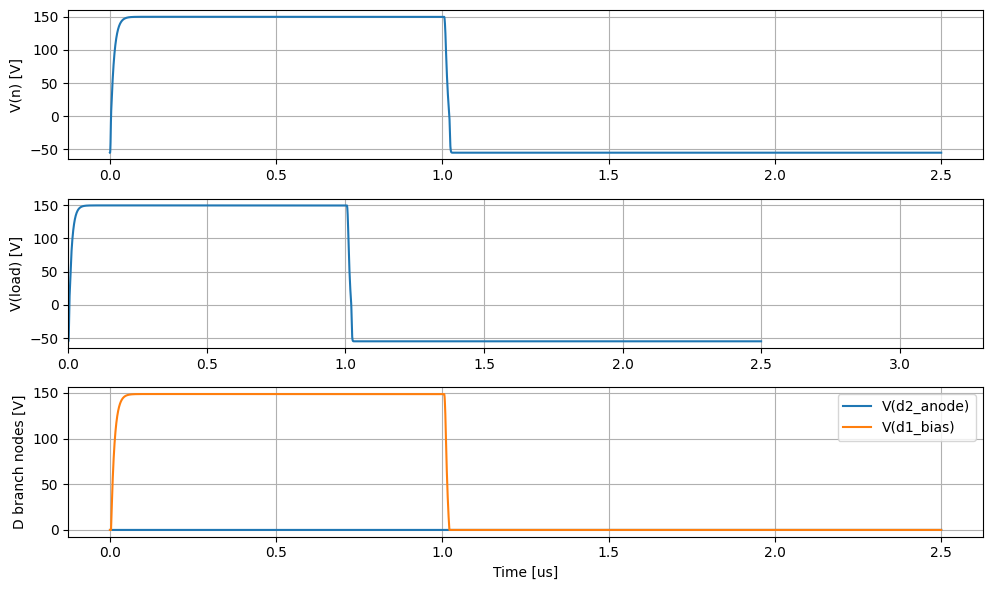

Simulation finished. Inspect the plots for the load pulse around the polarity flip times.


In [5]:
# fig5_behavioral_srd_gdt.py
# Behavioral PySpice model of Fig.5 (SRD + GDT + L) — pulse produced internally (no manual Iinj).
# Approximate model: storage caps for charge, voltage-controlled switches for GDT & snap behavior.
# Requirements: PySpice + ngspice installed.

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# PARAMETERS (tune these to match paper)
# -----------------------------
# Circuit / paper reference values (Table I–III)
L_val    = 0.1e-6      # H  (0.1 uH)
RL_val   = 50.0        # Ohm (load)
Rs_val   = 0.1         # Ohm (small series parasitic)
R1_val   = 16.0        # Ohm (from paper R1)
R2_val   = 16.0        # Ohm (from paper R2)
Cdsc_val = 26e-9       # F  (discharge capacitor; large value in paper)
Cind_val = 1e-12       # F  (parasitic inductor cap)
Cj1_val  = 9e-12       # F  (approx junction capacitance of D1 in Table II)
Cj2_val  = 1400e-12    # F  (junction capacitance of D2 approx)
# Storage caps (behavioral to model minority-carrier charge)
Cst1_val = 5e-12       # F  (small storage for D1)
Cst2_val = 2e-9        # F  (large storage for high-current D2)
# Resistances that set charge/discharge time-constants (approx minority lifetime)
Rcharge1 = 50.0        # Ohm  (gives tau ~ Cst1*Rcharge1)
Rcharge2 = 0.1         # Ohm  (fast charge path for D2)
Rdis1    = 1.0         # Ohm  (fast discharge path when snap occurs)
Rdis2    = 0.05        # Ohm

# GDT break parameters
Vb_gdt   = 55.0        # V   (breakdown voltage — tune)
R_gdt_on = 0.5         # Ohm when ON (arc resistance)
R_gdt_off= 1e9         # Ohm when OFF

# Diode models (simple ideal-ish)
VD1_drop = 1.0         # forward drop D1 (V)
VD2_drop = 0.7         # forward drop D2 (V)

# Input waveform timing (bipolar)
A1 = 55.0              # negative amplitude (V)
A2 = 150.0             # positive amplitude (V)
T1 = 1.0e-6            # duration of negative half (s)
T2 = 0.5e-6            # duration of positive half (s)
TR  = 5e-9             # rise/fall time (s)
PER = T1 + T2 + 1e-6   # period (s)

# Simulation settings
sim_end = 2.5e-6       # s
step_time = 0.05e-9    # s (small step for high-res)

# -----------------------------
# Build circuit
# -----------------------------
circuit = Circuit('Fig5_behavioral_SRD_GDT')

# Bipolar input source (Vin) connected to left side of L
# PULSE(Voff Von delay rise fall width period)
circuit.V('in', 'vin', circuit.gnd,
          f'PULSE({-A1} {A2} 0 {TR} {TR} {T1} {PER})')

# Inductor between vin and node n
circuit.L('L1', 'vin', 'n', L_val)
# small parasitic cap of inductor to ground
circuit.C('Lpar', 'n', circuit.gnd, Cind_val)

# Load branch: node 'n' -> RL -> ground (through small series Rs to mimic paper)
circuit.R('s', 'n', 'n_r', Rs_val)
circuit.R('L', 'n_r', circuit.gnd, RL_val)

# Effective capacitance at n_r: small D1 junction + GDT electrode + parasitic; we'll add explicit Ceff later
# A discharge capacitor Cdsc connected to D1 gate node in real hardware; here we connect between node and D1 branch.
circuit.C('eff', 'n_r', circuit.gnd, Cj1_val + Cind_val)  # baseline

# -----------------------------
# D1 branch: high-voltage SRD (modeled)
# Node convention:
#  - D1 anode tied to node 'd1_a'
#  - D1 cathode tied to node 'n' (shared)
# We'll approximate forward conduction by an ideal diode + series R,
# and store charge on Cst1 (anode-to-ground) via Rcharge1. When snap condition happens,
# a switch S_d1_dis connects Cst1 quickly to node causing discharge (reverse current).
# -----------------------------
# D1 branch nodes
circuit.R('R1', 'd1_bias', circuit.gnd, R1_val)     # bias resistor to ground (as in schematic)
circuit.D('D1', 'n', 'd1_bias', model='DIODE1')     # D1 between node n (cathode) and d1_bias (anode)
# small junction storage cap
circuit.C('Cst1', 'd1_bias', circuit.gnd, Cst1_val)
circuit.R('Rchg1', 'd1_bias', circuit.gnd, Rcharge1)

# Switch to emulate snap-off discharge of Cst1 into node when reverse condition occurs.
# We'll create a voltage-controlled switch S_d1 that closes (low resistance) when node 'n' voltage > a small threshold,
# representing that D1 is forced into reverse and discharges.
# Note: in ngspice/PySpice, switch uses an associated .model with Ron,Roff,Vt,Vh
circuit.S('d1snap', 'd1_bias', 'n', 'ctrl_d1_pos', circuit.gnd, model='SWD1')

# -----------------------------
# D2 branch + GDT: high-current diode + gas discharge tube
# Node convention:
#  - D2 cathode on RS to ground
#  - D2 anode connected to node 'n' through GDT switch
# We'll model:
#  - GDT as a voltage-controlled switch Sgdt with Vt = Vb_gdt
#  - D2 as diode with large storage cap Cst2 (anode side)
#  - When polarity flips, a switch S_d2snap will connect Cst2 to node quickly to discharge
# -----------------------------
# GDT switch: between node 'n' and the D2 anode node 'gdt_node'
circuit.S('gdt', 'n', 'gdt_node', 'ctrl_gdt_plus', circuit.gnd, model='SWGDT')
# series arc resistance when ON is modeled by R_arc (connected after gdt_node)
circuit.R('Rarc', 'gdt_node', 'd2_anode', R_gdt_on)
# D2 diode and series Rs to ground (RS is the series resistor in D2 branch)
circuit.D('D2', 'd2_anode', 'd2_cat', model='DIODE2')
circuit.R('RS', 'd2_cat', circuit.gnd, Rs_val)
# storage capacitor for D2
circuit.C('Cst2', 'd2_anode', circuit.gnd, Cst2_val)
circuit.R('Rchg2', 'd2_anode', circuit.gnd, Rcharge2)

# Switch to emulate very-fast snap discharge of Cst2 into node when D2 turns reverse
circuit.S('d2snap', 'd2_anode', 'n', 'ctrl_d2_pos', circuit.gnd, model='SWD2')

# -----------------------------
# DEVICE MODELS (ngspice .model-like)
# -----------------------------
# Simple diode models
# Note: PySpice exposes .model through netlist directive. We'll add model lines by appending to netlist
circuit.model('DIODE1', 'D', IS=1e-10, N=2, BV=12.9e3, IBV=1e-3)   # high-voltage diode approx
circuit.model('DIODE2', 'D', IS=1e-6, N=1, BV=400, IBV=1e-3)       # high-current diode approx

# Switch models (voltage-controlled)
# SW model format: .model name SW(Ron= Roff= Vt= Vh=)
# - Roff: high resistance when off
# - Ron: low resistance when on
# - Vt: threshold (control voltage) for switching
# - Vh: hysteresis (set small)
# We'll use control port as the node 'n' (voltage across control determines ON)
circuit.model('SWGDT', 'SW', Ron=R_gdt_on, Roff=R_gdt_off, Vt=Vb_gdt, Vh=0.0)
# For D1 and D2 snap switches we'll use thresholds tied to conditions — we'll use small Vt and monitor node voltages.
# Choose thresholds so the snap switch closes when the node polarity reverses and large reverse current appears
circuit.model('SWD1', 'SW', Ron=Rdis1, Roff=1e9, Vt=5.0, Vh=0.0)
circuit.model('SWD2', 'SW', Ron=Rdis2, Roff=1e9, Vt=1.0, Vh=0.0)

# -----------------------------
# CONTROLS (control nodes) -- small voltage sources to provide control signals for switches
# We need to reference control node names used in .S element signatures above:
# - ctrl_gdt_plus : control between ctrl_gdt_plus and gnd; use voltage at node 'n' as input
# - ctrl_d1_pos  : we can tie to node 'n' (positive sense) — for simplicity we create zero-imp sources
# - ctrl_d2_pos  : tie to node 'd2_anode' or node 'n' depending which condition you want
# In PySpice, the control nodes are simply nodes in the circuit; to be explicit we add a 0V source to connect them
# -----------------------------
circuit.V('ctrlgdt', 'ctrl_gdt_plus', circuit.gnd, 0@u_V)   # control node for GDT (voltage at 'n' is actually used by switch)
circuit.V('ctrld1', 'ctrl_d1_pos', circuit.gnd, 0@u_V)
circuit.V('ctrld2', 'ctrl_d2_pos', circuit.gnd, 0@u_V)

# Note: The ngspice switch S N+ N- V+ V- model uses the voltage between the two control nodes
# We have supplied them as separate nodes above; in this simplified mapping, SPICE will read voltage of control nodes.
# For correct behavior you may prefer to create behavioral voltage sources that replicate the needed control voltages,
# e.g., a B-source that sets ctrl node to the instantaneous node voltage. However many SPICE implementations allow using a node name directly.

# -----------------------------
# SIMULATION
# -----------------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=step_time, end_time=sim_end)

# -----------------------------
# PLOTTING
# -----------------------------
time = np.array(analysis.time)
v_node = np.array(analysis.nodes['n'])
v_load = np.array(analysis.nodes['n_r'])
v_d2an = np.array(analysis.nodes['d2_anode'])
v_d1 = np.array(analysis.nodes['d1_bias'])

plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(time*1e6, v_node)
plt.ylabel('V(n) [V]')
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(time*1e6, v_load)
plt.ylabel('V(load) [V]')
plt.grid(True)
plt.xlim(0, 2.2*(T1+T2)*1e6)  # show couple periods

plt.subplot(3,1,3)
plt.plot(time*1e6, v_d2an, label='V(d2_anode)')
plt.plot(time*1e6, v_d1, label='V(d1_bias)')
plt.ylabel('D branch nodes [V]')
plt.xlabel('Time [us]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print('Simulation finished. Inspect the plots for the load pulse around the polarity flip times.')


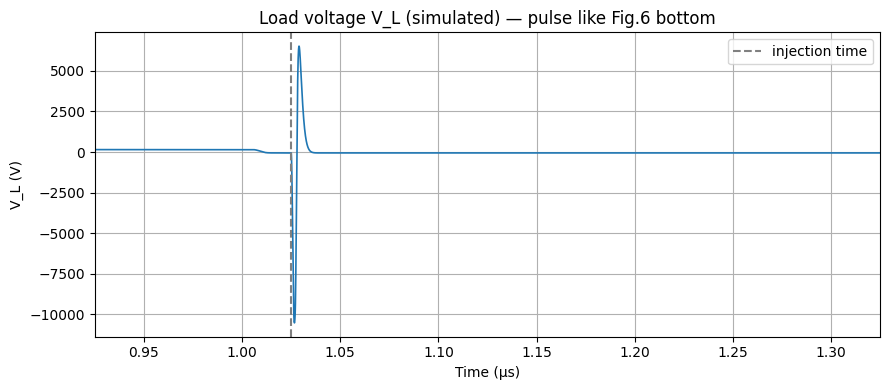

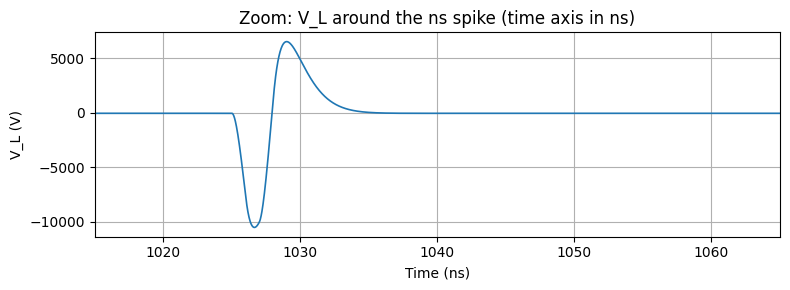

Done — VL data saved to VL_pulse_fig6_data.txt


In [6]:
# vl_pulse_fig6.py
# Produces the VL waveform (sharp nanosecond pulse) like Fig.6 bottom.
# Uses a bipolar Vin and injects a short reverse current (Iinj) at the polarity flip to emulate diode snap-off.
# Requirements: PySpice + ngspice installed.

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# Parameters (tuneable)
# -----------------------
# Input bipolar timing (match Fig.6)
A1 = 55.0            # magnitude of negative half (V)
A2 = 150.0           # magnitude of positive half (V)
T1 = 1.0e-6          # negative half duration (s)
T2 = 0.5e-6          # positive half duration (s)
TR = 5e-9            # rise/fall time (s)
PER = T1 + T2 + 0.5e-6

# Circuit
L_val = 0.1e-6       # H (0.1 µH)
Ceff  = 10e-12       # F (effective capacitance, tune to adjust pulse width)
RL    = 50.0         # Ohm (load)
Rs    = 0.1          # small series resistance

# Injected reverse current parameters (emulates IRM)
# Place injection slightly after the polarity flip (simulate storage delay)
tsd_est = 25e-9      # estimated storage delay after polarity flip (s) -> tune
t_inject = T1 + tsd_est   # inject time ~ end of negative half + storage delay
Ipeak = 300.0        # A (peak of injected reverse current) — tune to set VL amplitude
inj_width = 1.0e-9   # s (very short current pulse to get ns spike)

# Simulation settings
sim_end = T1 + T2 + 0.5e-6
step_time = 0.02e-9  # fine time resolution to capture ns pulse

# -----------------------
# Build circuit
# -----------------------
circuit = Circuit('VL_pulse_fig6')

# Bipolar input source (Vin)
circuit.V('in', 'vin', circuit.gnd, f'PULSE({-A1} {A2} 0 {TR} {TR} {T1} {PER})')

# Inductor between vin and node 'n'
circuit.L('1', 'vin', 'n', L_val)
# small parasitic to ground
circuit.C('par', 'n', circuit.gnd, 1e-12)

# series parasitic and load
circuit.R('rs', 'n', 'n_r', Rs)
circuit.R('rl', 'n_r', circuit.gnd, RL)

# effective capacitance at load node (Ceff ~ Cj1 + Cgdt + Cind)
circuit.C('ceff', 'n_r', circuit.gnd, Ceff)

# Injected current to emulate IRM (a short pulse)
# PULSE(Ioff Ion Delay Tr Tf PW Period)
Iexpr = f'PULSE(0 {Ipeak} {t_inject} 1n 1n {inj_width} {sim_end})'
circuit.I('inj', 'n_r', circuit.gnd, Iexpr)

# -----------------------
# Simulate
# -----------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=step_time, end_time=sim_end)

# -----------------------
# Extract & plot VL
# -----------------------
time = np.array(analysis.time)
v_load = np.array(analysis.nodes['n_r'])

# Plot full timeframe with indication of injection time
plt.figure(figsize=(9,4))
plt.plot(time * 1e6, v_load, linewidth=1.2)
plt.axvline(x=t_inject * 1e6, color='gray', linestyle='--', label='injection time')
plt.title('Load voltage V_L (simulated) — pulse like Fig.6 bottom')
plt.xlabel('Time (µs)')
plt.ylabel('V_L (V)')
plt.grid(True)

# zoom region around the pulse for clear view
zoom_center = t_inject
zoom_span = 0.4e-6   # show ~0.4 µs window (adjust)
plt.xlim((zoom_center - 0.1e-6) * 1e6, (zoom_center + 0.3e-6) * 1e6)

plt.legend()
plt.tight_layout()
plt.show()

# Also zoom very tightly to show nanosecond spike shape
plt.figure(figsize=(8,3))
plt.plot(time * 1e9, v_load, linewidth=1.2)
plt.title('Zoom: V_L around the ns spike (time axis in ns)')
plt.xlabel('Time (ns)')
plt.ylabel('V_L (V)')
plt.grid(True)
# set tight x-limits around the spike
plt.xlim((t_inject - 10e-9) * 1e9, (t_inject + 40e-9) * 1e9)
plt.tight_layout()
plt.show()

# Save data
np.savetxt('VL_pulse_fig6_data.txt', np.column_stack((time, v_load)), header='time(s) Vload(V)')
print('Done — VL data saved to VL_pulse_fig6_data.txt')
